In [1]:
from qiskit import IBMQ
import warnings
import sys
sys.path.insert(1, 'Scripts')
#warnings.filterwarnings('ignore')

# Load Account and Choose Backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_lima'
backend = provider.get_backend(name)

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
# Own Functions
from qiskit import QuantumCircuit, transpile, execute
from qiskit.tools.monitor import job_monitor

# Numerical/Stats pack
import csv
import pandas as pd
import numpy as np
import scipy.stats as ss
import numpy.linalg as nl

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# For optimization
from cvxopt import matrix, solvers


file_address = 'LimaData2/'
shots = 8192

In [3]:
def param_record(backend, itr=32, shots=8192, if_write=True, file_address=''):
    """Write backend property into an array of dict 
       and save as csv if permissible.

    Args:
      backend: IBMQBackend
        backend from provider.get_backend().
      itr: int
        number of iterations of job submission.
      shots: int
        number of shots per each job submission.
      if_write: boolean
        True if save the properties as a csv file.
      file_address: string
        The relative file address to save backend properties. 
        Ends with '/' if not empty
        The default is ''.

    Returns: numpy array
      An array of dicts. Each dict records all characterization of one qubit.
    """
    prop_dict = backend.properties().to_dict()
    nQubits = len(prop_dict['qubits'])
    backend_name = prop_dict['backend_name']

    target_qubits = range(nQubits)
    allParam = np.array([])
    for target_qubit in target_qubits:
        params = {
            'qubit':
            target_qubit,
            'update_date':
            prop_dict['last_update_date'],
            'T1':
            prop_dict['qubits'][target_qubit][0]['value'],
            'T2':
            prop_dict['qubits'][target_qubit][1]['value'],
            'freq':
            prop_dict['qubits'][target_qubit][2]['value'],
            'readout_err':
            prop_dict['qubits'][target_qubit][3]['value'],
            'pm0p1':
            prop_dict['qubits'][target_qubit][4]['value'],
            'pm1p0':
            prop_dict['qubits'][target_qubit][5]['value'],
            'id_error':
            prop_dict['gates'][4 * target_qubit]['parameters'][0]['value'],
            'id_len':
            prop_dict['gates'][4 * target_qubit]['parameters'][1]['value'],
            'u1_error':
            prop_dict['gates'][4 * target_qubit + 1]['parameters'][0]['value'],
            'u1_len':
            prop_dict['gates'][4 * target_qubit + 1]['parameters'][1]['value'],
            'u2_error':
            prop_dict['gates'][4 * target_qubit + 2]['parameters'][0]['value'],
            'u2_len':
            prop_dict['gates'][4 * target_qubit + 2]['parameters'][1]['value'],
            'u3_error':
            prop_dict['gates'][4 * target_qubit + 3]['parameters'][0]['value'],
            'u3_len':
            prop_dict['gates'][4 * target_qubit + 3]['parameters'][1]['value'],
            'itr':
            itr,
            'shots':
            shots,
        }
        allParam = np.append(allParam, params)

    if if_write:
        with open(file_address + 'Params.csv', mode='w', newline='') as sgm:
            param_writer = csv.writer(sgm,
                                      delimiter=',',
                                      quotechar='"',
                                      quoting=csv.QUOTE_MINIMAL)
            for pa in allParam:
                for key, val in pa.items():
                    param_writer.writerow([key, val])
                param_writer.writerow(['End'])

    return allParam

In [4]:
# Record Device Parameters
param_record(backend, itr=8, shots=shots, if_write=True, file_address=file_address)

array([{'qubit': 0, 'update_date': datetime.datetime(2021, 3, 22, 16, 9, 23, tzinfo=tzlocal()), 'T1': 129.46224122259403, 'T2': 211.8032029666661, 'freq': 5.029682057913614, 'readout_err': -0.33574155258829724, 'pm0p1': 0.01770000000000005, 'pm1p0': 0.0254, 'id_error': 0.00019047479643498932, 'id_len': 35.55555555555556, 'u1_error': 0.00026175003610419363, 'u1_len': 35.55555555555556, 'u2_error': 0.0003555210092607151, 'u2_len': 35.55555555555556, 'u3_error': 0.0005559819978295073, 'u3_len': 35.55555555555556, 'itr': 8, 'shots': 8192},
       {'qubit': 1, 'update_date': datetime.datetime(2021, 3, 22, 16, 9, 23, tzinfo=tzlocal()), 'T1': 59.59718918758183, 'T2': 102.42423307382502, 'freq': 5.128367188834747, 'readout_err': -0.3183491230373718, 'pm0p1': 0.03160000000000007, 'pm1p0': 0.053200000000000025, 'id_error': 0.0007022201253724391, 'id_len': 35.55555555555556, 'u1_error': 0, 'u1_len': 0, 'u2_error': 0, 'u2_len': 0, 'u3_error': 0, 'u3_len': 0, 'itr': 8, 'shots': 8192},
       {'qubi

In [5]:
num_qubits = 5
num_repeat = 2

circs = []
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    circ_mean = QuantumCircuit(num_qubits, num_qubits, name=target)
    for i in range(num_qubits):
        if target[i] == '1':
            circ_mean.x(num_qubits-1-i)  # follow measurement order
    circ_mean.measure(range(num_qubits), range(num_qubits))
    circ_mean_trans = transpile(circ_mean, backend, initial_layout=range(num_qubits))
    circ_mean_trans .draw(output='mpl',filename=file_address+target+"circ.jpg")
    for i in range(num_repeat):
        circs.append(circ_mean_trans.copy(target+"-{:d}" .format(i)))

In [6]:
job_m0 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
job_monitor(job_m0)

Job Status: job has successfully run


In [7]:
job_m1 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
job_monitor(job_m1)

Job Status: job has successfully run


In [8]:
job_m2 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
job_monitor(job_m2)

Job Status: job has successfully run


In [9]:
job_m3 = execute(circs, backend=backend, shots=shots, memory=True, optimization_level=0)
job_monitor(job_m3)

Job Status: job has successfully run


In [10]:
# Save bits
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    readout_basis = np.array([])
    for job in [job_m0, job_m1, job_m2, job_m3]:
        res_basis = job.result()
        for i in range(num_repeat):
            readout_basis = np.append(readout_basis, res_basis.get_memory(experiment=(target+"-{:d}" .format(i))))
        
    # Save
    np.savetxt(file_address + 'Basis'+target+'.csv', readout_basis, delimiter=',', fmt='%s')

# Check Matrix

In [11]:
def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec

In [12]:
# Read Bits
from collections import Counter
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/(shots*num_repeat*4)
    
mean_mat,mean_mat.sum(axis=0)

(array([[9.64660645e-01, 3.53698730e-02, 3.52935791e-02, ...,
         0.00000000e+00, 1.52587891e-05, 0.00000000e+00],
        [7.64465332e-03, 9.41070557e-01, 2.13623047e-04, ...,
         3.66210938e-04, 0.00000000e+00, 0.00000000e+00],
        [4.11987305e-03, 4.57763672e-05, 9.37423706e-01, ...,
         0.00000000e+00, 4.11987305e-04, 1.52587891e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.50427246e-01, 5.03540039e-04, 2.84118652e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.06811523e-04, 7.46887207e-01, 2.85339355e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.30407715e-03, 5.61523438e-03, 7.25097656e-01]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [13]:
np.set_printoptions(suppress=True, threshold=sys.maxsize)
print(mean_mat)

[[0.96466064 0.03536987 0.03529358 0.00141907 0.07154846 0.00254822
  0.00270081 0.00009155 0.04782104 0.0018158  0.00175476 0.00009155
  0.00318909 0.00009155 0.00013733 0.         0.10978699 0.0042572
  0.00430298 0.00012207 0.00836182 0.00033569 0.00028992 0.00001526
  0.00576782 0.00019836 0.00018311 0.         0.00050354 0.
  0.00001526 0.        ]
 [0.00764465 0.94107056 0.00021362 0.03514099 0.00076294 0.06813049
  0.00007629 0.00280762 0.00028992 0.04501343 0.00001526 0.00193787
  0.         0.00332642 0.         0.00012207 0.00083923 0.10839844
  0.00006104 0.00431824 0.00006104 0.00740051 0.         0.00019836
  0.00001526 0.00540161 0.         0.00016785 0.         0.00036621
  0.         0.        ]
 [0.00411987 0.00004578 0.93742371 0.03495789 0.0002594  0.00001526
  0.0677948  0.00268555 0.00022888 0.         0.04615784 0.00152588
  0.00001526 0.         0.00315857 0.00009155 0.00048828 0.00004578
  0.10610962 0.00384521 0.00004578 0.         0.00788879 0.00024414
  0.000

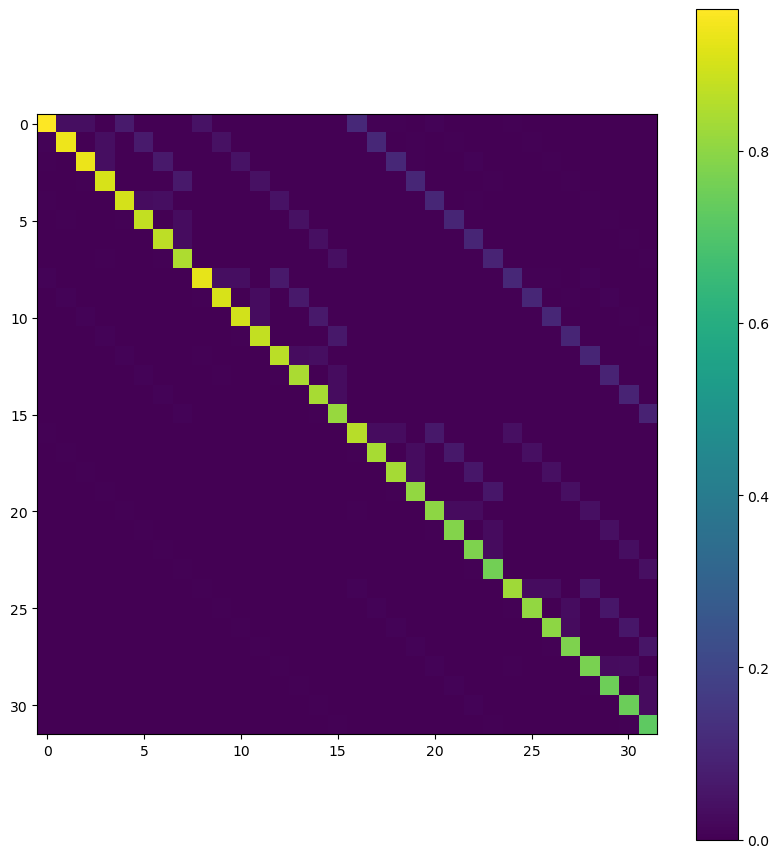

In [14]:
plt.rcParams["figure.figsize"] = (10, 11)
plt.rcParams["figure.dpi"] = 100

plt.imshow(mean_mat)
plt.colorbar()
plt.show()

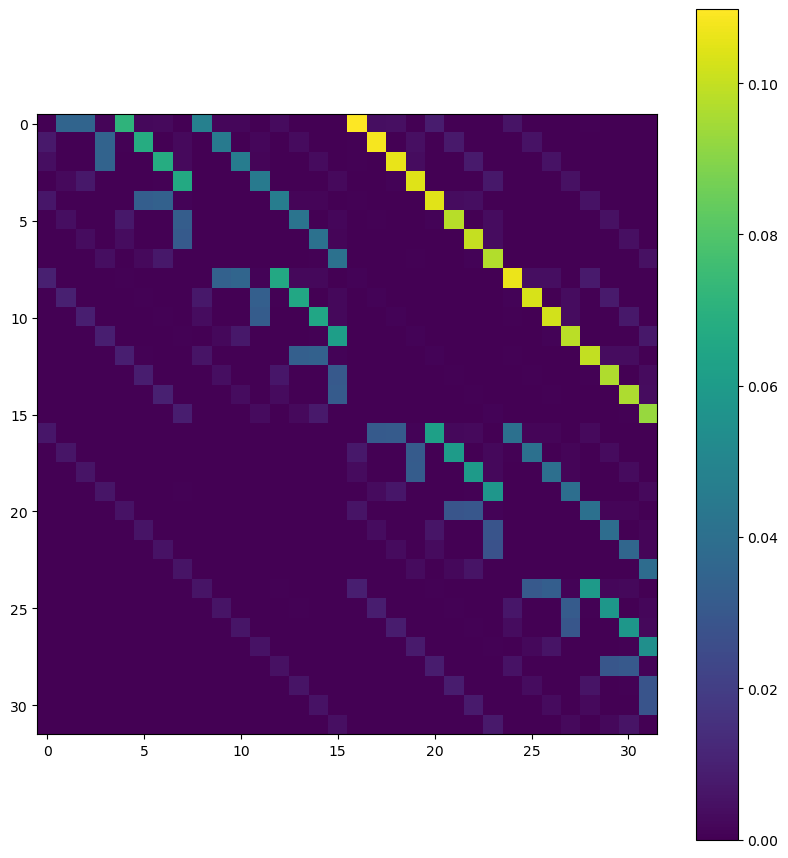

In [15]:
# Zero out diagonal
# Note that prob_meas0_prep1 is usually the dominant factor in the readout error due to relaxation during the measurement process. 
zero_diag = np.copy(mean_mat)
for i in range(2**num_qubits):
    zero_diag[i,i] = 0

plt.imshow(zero_diag)
plt.colorbar()
plt.show()

# Hadamard

In [16]:
circ_had = QuantumCircuit(num_qubits, num_qubits, name=target)
for i in range(num_qubits):
    circ_had.h(i)
circ_had.measure(range(num_qubits), range(num_qubits))
circ_had_trans = transpile(circ_had, backend, initial_layout=range(num_qubits))
circ_had_trans.draw(output='mpl',filename=file_address+"had_circ.jpg")

had_circs = []
for i in range(64):
    had_circs.append(circ_had_trans.copy("had-{:d}".format(i)))

In [17]:
job_had = execute(had_circs, backend=backend, shots=shots, memory=True, optimization_level=0)
job_monitor(job_had)

Job Status: job has successfully run


In [18]:
# Save bits
res_had = job_had.result()
readout_had = np.array([])
for bn in range(64):
    readout_had = np.append(readout_had, res_had.get_memory(experiment=("had-{:d}".format(bn))))

# Save
np.savetxt(file_address + 'Had.csv', readout_had, delimiter=',',fmt='%s')

Ideal prob = 0.03125


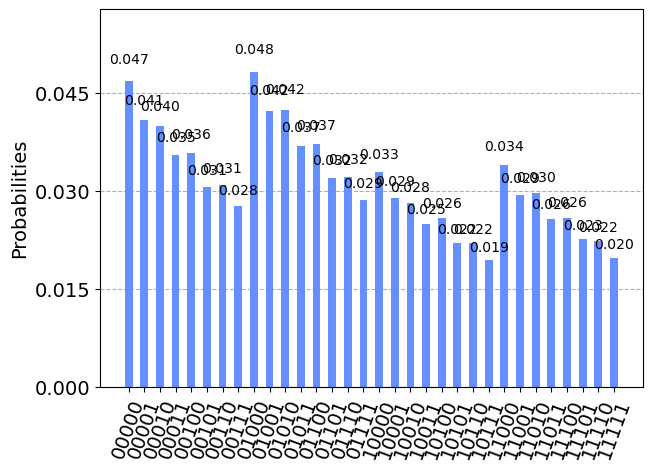

In [19]:
# Read bits
had_strings = np.genfromtxt(file_address + 'Had.csv', delimiter=',',dtype=np.str)

print("Ideal prob = {:}".format(1/2**num_qubits))
from qiskit.visualization import plot_histogram
plot_histogram(Counter(had_strings))

In [20]:
num_group = 8
had_groups = np.split(had_strings, num_group)
had_probs = np.zeros((2**num_qubits,num_group))
for i in range(num_group):
    for d in had_groups[i]:
        had_probs[int(d,2),i] += 1

had_probs = had_probs/had_probs.sum(axis=0)

# plt.figure(figsize=(20,6)) 
# plt.plot(had_probs[0], label='Pr('+'0'*num_qubits+'|'+'0'*num_qubits+')')
# plt.plot(had_probs[2**num_qubits-1], label='Pr('+'1'*num_qubits+'|'+'1'*num_qubits+')')
# plt.title("Outcomes from hadamard circuits")
# plt.legend()
# plt.show()

# print(np.mean(had_probs[0]), np.mean(had_probs[2**num_qubits-1]))

In [21]:
def read_filter_data(file_address=''):
    cali_data = {}
    for bn in range(2**num_qubits):
        target = format(bn, "0{:d}b".format(num_qubits))
        cali_data[target]=np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
    return cali_data
def getData0(data, num_group, num_qubits):
    # Split bit string data
    groups = np.split(data, num_group)
    
    probs = np.zeros((2**num_qubits, num_group))
    for i in range(num_group):
        for d in groups[i]:
            probs[int(d,2),i] += 1
    
    # Normalize
    probs = probs/probs.sum(axis=0)
    return probs

In [22]:
# Read test circuit data
cali = read_filter_data(file_address=file_address)
cali_probs = {}
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    cali_probs[target] = getData0(cali[target], num_group, num_qubits)

In [23]:
cali_all0 = 0
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    cali_all0 += cali_probs[target][0]
    
cali_all1 = 0
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    cali_all1 += cali_probs[target][2**num_qubits - 1] 

Basis
0.04070854187011719 0.023381710052490234
Hadamard
0.04679298400878906 0.019716262817382812


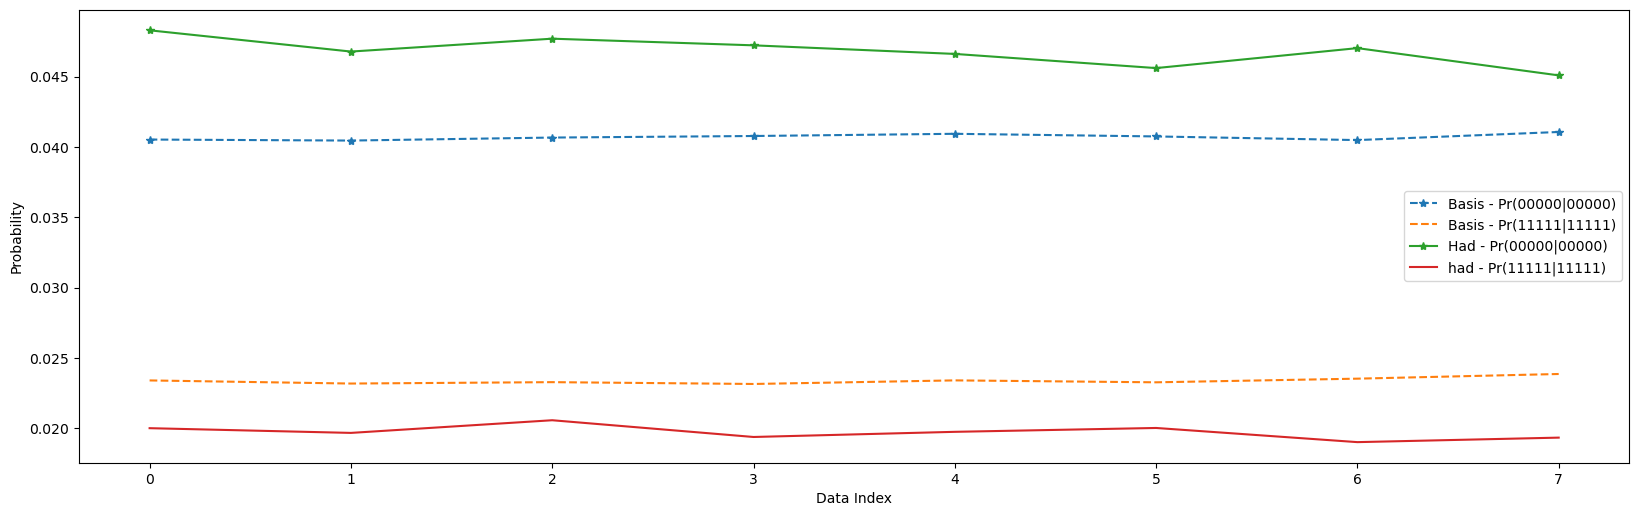

In [24]:
print("Basis")
print(np.mean(cali_all0/2**num_qubits), np.mean(cali_all1/2**num_qubits))
print("Hadamard")
print(np.mean(had_probs[0]), np.mean(had_probs[2**num_qubits-1]))

plt.figure(figsize=(20,6)) 
plt.plot(cali_all0/2**num_qubits, marker = '*', linestyle = '--', label='Basis - Pr('+'0'*num_qubits+'|'+'0'*num_qubits+')')
plt.plot(cali_all1/2**num_qubits, linestyle = '--', label='Basis - Pr('+'1'*num_qubits+'|'+'1'*num_qubits+')')
plt.plot(had_probs[0], marker = '*', label='Had - Pr('+'0'*num_qubits+'|'+'0'*num_qubits+')')
plt.plot(had_probs[2**num_qubits-1], label='had - Pr('+'1'*num_qubits+'|'+'1'*num_qubits+')')
plt.xlabel("Data Index")
plt.ylabel("Probability")
plt.legend()
plt.show()

# Ind Filter

In [25]:
job_ind = execute(had_circs, backend=backend, shots=shots, memory=True, optimization_level=0)
job_monitor(job_ind)

Job Status: job has successfully run


In [26]:
# Save bits
res_ind = job_ind.result()
readout_ind = np.array([])
for bn in range(64):
    readout_ind = np.append(readout_ind, res_ind.get_memory(experiment=("had-{:d}".format(bn))))

with open(file_address + 'Filter_data.csv', mode='w') as sgr:
    read_writer = csv.writer(sgr,
                             delimiter=',',
                             quotechar='"',
                             quoting=csv.QUOTE_MINIMAL)
    read_writer.writerow(readout_ind)

Qubit 4
Given Lambdas [0.915  0.9514]


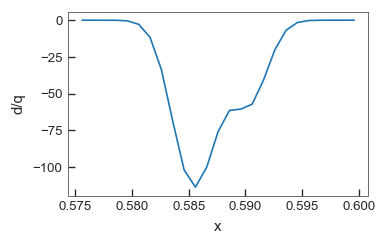

Final Accepted Posterior Lambdas
M: 113.796 Maximizer: 0.585511 pi_obs = 157.968 pi_Q(prior) = 1.38817
Progress: 99.997%
Accepted Number N: 315, fraction 0.008
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.95317485 0.78007192]
Posterior Lambda Mode [0.9806365  0.80284913]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0218715
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


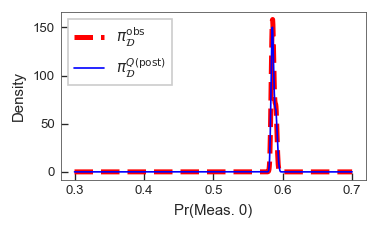

Qubit 3
Given Lambdas [0.9062 0.9441]


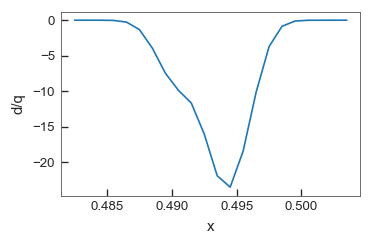

Final Accepted Posterior Lambdas
M: 23.7429 Maximizer: 0.494235 pi_obs = 184.13 pi_Q(prior) = 7.75515
Progress: 99.997%
Accepted Number N: 1700, fraction 0.043
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.89633629 0.91006545]
Posterior Lambda Mode [0.92230825 0.93971227]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00493046
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


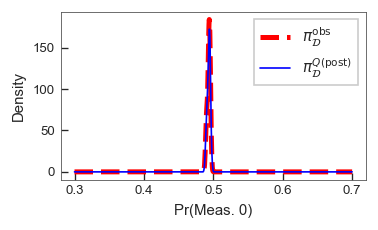

Qubit 2
Given Lambdas [0.9438 0.9661]


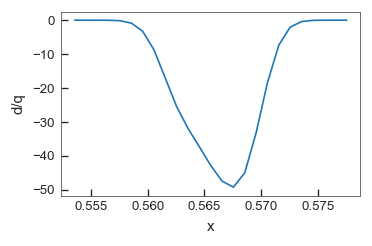

Final Accepted Posterior Lambdas
M: 49.2787 Maximizer: 0.567459 pi_obs = 128.615 pi_Q(prior) = 2.60994
Progress: 99.997%
Accepted Number N: 834, fraction 0.021
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.95209831 0.81957007]
Posterior Lambda Mode [0.97861499 0.8458205 ]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00849851
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


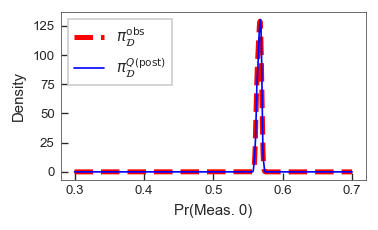

Qubit 1
Given Lambdas [0.9468 0.9684]


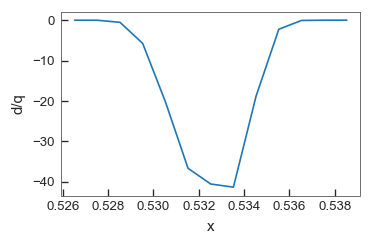

Final Accepted Posterior Lambdas
M: 42.7662 Maximizer: 0.533214 pi_obs = 253.174 pi_Q(prior) = 5.91996
Progress: 99.997%
Accepted Number N: 940, fraction 0.024
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.93718829 0.872609  ]
Posterior Lambda Mode [0.96882618 0.90414414]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00518152
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


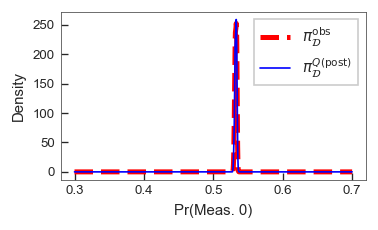

Qubit 0
Given Lambdas [0.9746 0.9823]


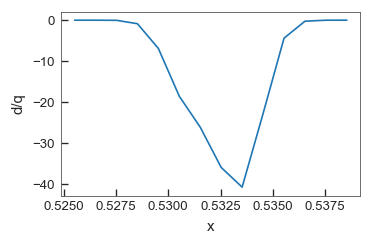

Final Accepted Posterior Lambdas
M: 41.4089 Maximizer: 0.533308 pi_obs = 260.245 pi_Q(prior) = 6.28476
Progress: 99.997%
Accepted Number N: 961, fraction 0.024
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94616343 0.88137881]
Posterior Lambda Mode [0.97669509 0.91154145]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.0042349
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


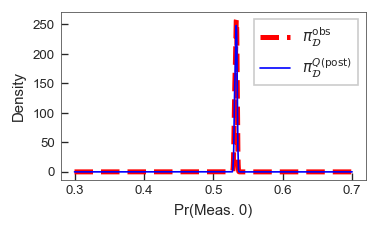

In [27]:
import measfilter as mf
ind_filter = mf.MeasFilter([4, 3, 2, 1,0], file_address=file_address)
ind_filter.inference(seed=14687,show_denoised=False,shots_per_point=8192)

In [28]:
ind_filter.mean()

{'Qubit4': array([0.95317485, 0.78007192]),
 'Qubit3': array([0.89633629, 0.91006545]),
 'Qubit2': array([0.95209831, 0.81957007]),
 'Qubit1': array([0.93718829, 0.872609  ]),
 'Qubit0': array([0.94616343, 0.88137881])}

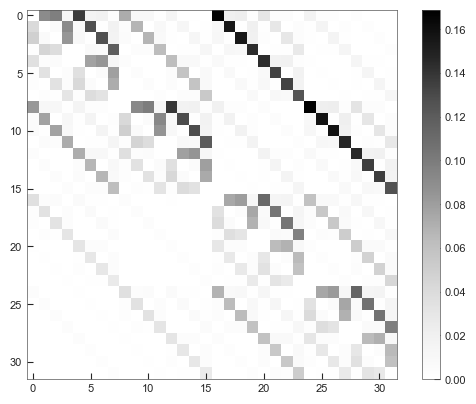

In [29]:
# Zero out diagonal
# Note that prob_meas0_prep1 is usually the dominant factor in the readout error due to relaxation during the measurement process. 
ind_zero_diag = np.copy(ind_filter.mat_mean)
for i in range(2**num_qubits):
    ind_zero_diag[i,i] = 0

plt.imshow(ind_zero_diag)
plt.colorbar()
plt.show()

# Hadamard Error Filtering

In [30]:
def find_least_norm(nQubits, ptilde):
    # Formulation
    Q = 2 * matrix(np.identity(2**nQubits))
    p = -2 * matrix(ptilde)

    G = -matrix(np.identity(2**nQubits))
    h = matrix(np.zeros(2**nQubits))

    A = matrix(np.ones(2**nQubits), (1, 2**nQubits))
    b = matrix(1.0)

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, h, A, b)
    return sol['status'], sol['x']


def dictToVec(nQubits, counts):
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def vecToDict(nQubits, shots, vec):
    counts = {}
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i)
        counts[key] = int(vec[i] * shots)
    return counts

def meas_dist(true_probs, real_counts):
    total_counts = sum(real_counts.values())
    counts_off = 0
    for key in real_counts:
        counts_off += np.abs(real_counts[key] - true_probs[int(key,2)]*total_counts)
        
    return counts_off/total_counts

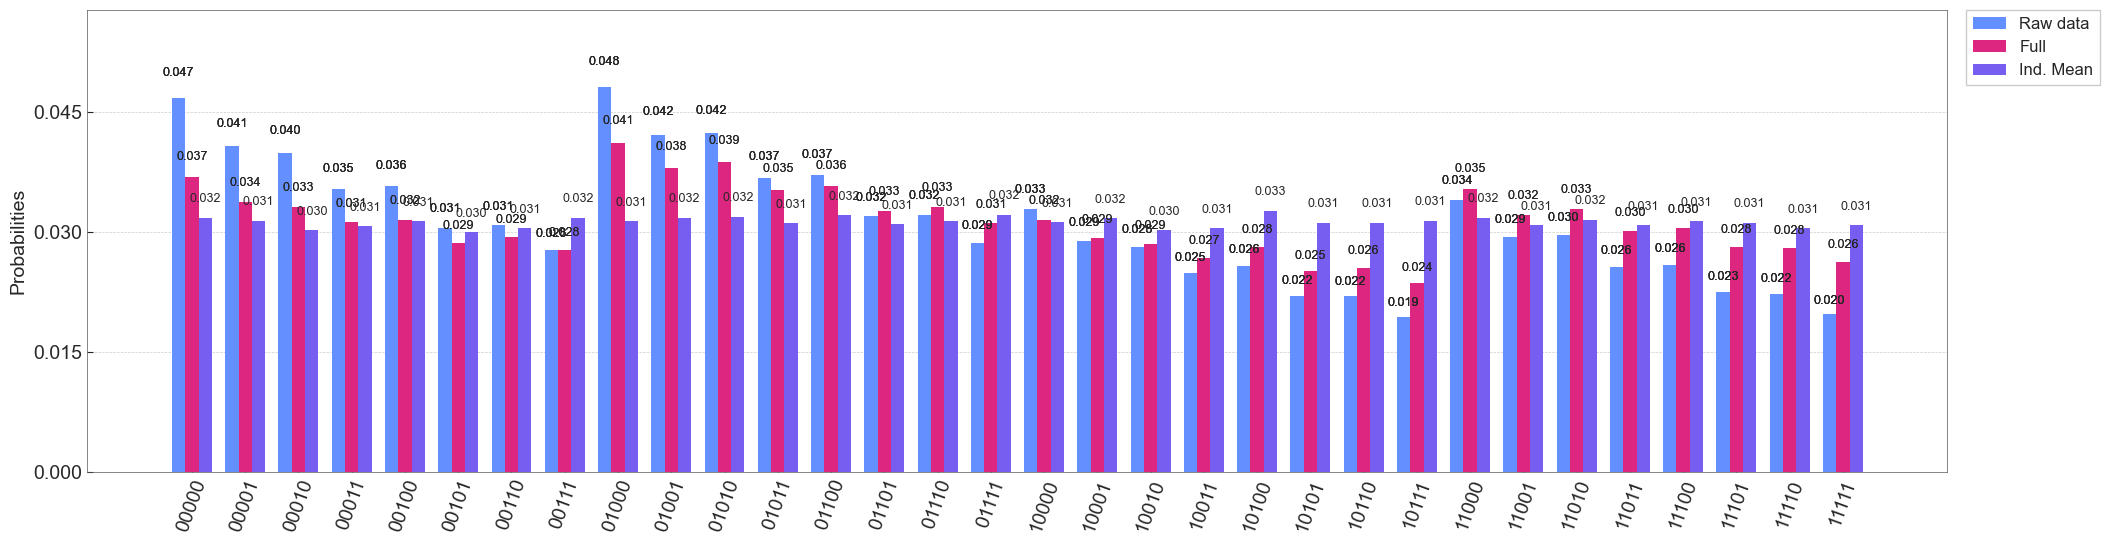

In [31]:
real_counts = Counter(had_strings)
real_vec = dictToVec(num_qubits,real_counts)/(shots*64)
full_status, full_vec = find_least_norm(num_qubits, nl.solve(mean_mat, real_vec))
full_counts = vecToDict(num_qubits, shots*64, full_vec)
ind_counts = ind_filter.filter_mean(real_counts)

legend = ["Raw data", "Full",  "Ind. Mean"]
plot_histogram([real_counts, full_counts, ind_counts], legend=legend,  figsize=(24, 6))

In [32]:
had_probs = [1/2**num_qubits]*(2**num_qubits)
print("Raw: total probalities dist from true = {:.4f}".format(meas_dist(had_probs, real_counts)))
print("Full A: total probalities dist from true = {:.4f}".format(meas_dist(had_probs, full_counts)))
print("Ind. Mean: total probalities dist from true = {:.4f}".format(meas_dist(had_probs, ind_counts)))

Raw: total probalities dist from true = 0.1975
Full A: total probalities dist from true = 0.1063
Ind. Mean: total probalities dist from true = 0.0153
